***
# Modele de prédiction
***

In [1]:
# ====== Importer les library ====== #
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


pd.set_option('display.max_columns', None)

In [2]:
# ====== Déterminer les path ====== #
import os
cwd = os.getcwd()

df_path = cwd + '\\dataframe\\'

In [3]:
# ====== Importer les df ====== #
df = pd.read_hdf(df_path + 'df_merge.h5')

df.head(2)

,IDENTITY_ATTACK,INSULT,PROFANITY,SEVERE_TOXICITY,THREAT,TOXICITY,comment_count,like_count,message_comments,mainTopic,message_posts,secondTopic,shares,title,time_difference,year,month,weekday,IDENTITY_ATTACK_cube,INSULT_cube,PROFANITY_cube,SEVERE_TOXICITY_cube,THREAT_cube,TOXICITY_cube,comment_count_cube,like_count_cube,shares_cube,messages_clean,emojis,emojis_text,positive,neutral,negative,emoji_count
0,0.102216,0.651296,0.664565,0.350583,0.029933,0.588517,0,0,"Faux, ce ne sera jamais le temps pour lui car ...",composer-preview,HÉLÈNE BUZZETTI / Jagmeet Singh a soutenu que ...,7FJ4TUHKEFEXFIZI6DY2WAQE4E,0,Les incohérences de l’ingérence,3.0,2023,6,4,0.467562,0.866814,0.872661,0.705121,0.310492,0.838017,0.0,0.0,0.0,Faux jamais temps réélu parti crève faim Jamai...,[],[],0.077610,0.130838,0.791552,0
1,0.005476,0.167515,0.255499,0.006981,0.005647,0.176317,1,1,Mon dieu!! On nous prend sérieusement pour des...,composer-preview,HÉLÈNE BUZZETTI / Jagmeet Singh a soutenu que ...,7FJ4TUHKEFEXFIZI6DY2WAQE4E,0,Les incohérences de l’ingérence,18.0,2023,6,4,0.176257,0.551253,0.634546,0.191119,0.178081,0.560745,1.0,1.0,0.0,dieu prend sérieusement idiots,[],[],0.697028,0.047872,0.255100,0


In [4]:
df_model = df.copy()
# df_model['parent_binary'] = np.where(df_model['parent'].isna(), 0, 1)
df_model['comments_binary'] = np.where(df_model['comment_count']==0, 0, 1)

col_to_keep = ['IDENTITY_ATTACK', 'INSULT', 'PROFANITY', 'SEVERE_TOXICITY', 'THREAT', 'TOXICITY', 'like_count', 'shares', 'time_difference', 'year', 'month', 'weekday', 'year', 'month', 'weekday', 'positive', 'negative', 'emoji_count', 'comments_binary']
# col_to_keep = ['IDENTITY_ATTACK_cube', 'INSULT_cube', 'PROFANITY_cube', 'SEVERE_TOXICITY_cube', 'THREAT_cube', 'TOXICITY_cube', 'like_count_cube', 'shares_cube', 'time_difference', 'year', 'month', 'weekday', 'comments_binary']
# col_to_keep = ['IDENTITY_ATTACK_cube', 'INSULT_cube', 'PROFANITY_cube', 'SEVERE_TOXICITY_cube', 'THREAT_cube', 'TOXICITY_cube', 'like_count_cube', 'shares_cube', 'time_difference', 'year', 'month', 'weekday', 'comment_count']


df_model = df_model[col_to_keep]
df_model.head()

,IDENTITY_ATTACK,INSULT,PROFANITY,SEVERE_TOXICITY,THREAT,TOXICITY,like_count,shares,time_difference,year,month,weekday,year,month,weekday,positive,negative,emoji_count,comments_binary
0,0.102216,0.651296,0.664565,0.350583,0.029933,0.588517,0,0,3.0,2023,6,4,2023,6,4,0.077610,0.791552,0,0
1,0.005476,0.167515,0.255499,0.006981,0.005647,0.176317,1,0,18.0,2023,6,4,2023,6,4,0.697028,0.255100,0,1
2,0.029144,0.269578,0.016753,0.006104,0.005864,0.246033,0,0,86.0,2023,6,4,2023,6,4,0.243069,0.667599,0,0
3,0.036105,0.402434,0.479813,0.023411,0.008220,0.372227,0,0,94.0,2023,6,4,2023,6,4,0.685404,0.189553,0,0
4,0.280349,0.520819,0.163573,0.169603,0.008790,0.439655,0,0,95.0,2023,6,4,2023,6,4,0.158446,0.599248,0,0


In [19]:
# Encode
from sklearn.preprocessing import OrdinalEncoder

# test = df_model.copy()
ordinal_encoder = OrdinalEncoder()
df_model['year'] = ordinal_encoder.fit_transform(df_model[['year']])
df_model.head(2)

,IDENTITY_ATTACK_cube,INSULT_cube,PROFANITY_cube,SEVERE_TOXICITY_cube,THREAT_cube,TOXICITY_cube,like_count_cube,shares_cube,time_difference,year,month,weekday,comments_binary
0,0.467562,0.866814,0.872661,0.705121,0.310492,0.838017,-0.683319,-1.183482,3.0,3.0,6,4,0
1,0.176257,0.551253,0.634546,0.191119,0.178081,0.560745,0.734104,-1.183482,18.0,3.0,6,4,1


In [18]:
# Scale values
from sklearn.preprocessing import StandardScaler
df_model[['like_count_cube', 'shares_cube']] = StandardScaler().fit_transform(df_model[['like_count_cube', 'shares_cube']])
df_model.head()

,IDENTITY_ATTACK_cube,INSULT_cube,PROFANITY_cube,SEVERE_TOXICITY_cube,THREAT_cube,TOXICITY_cube,like_count_cube,shares_cube,time_difference,year,month,weekday,comments_binary
0,0.467562,0.866814,0.872661,0.705121,0.310492,0.838017,-0.683319,-1.183482,3.0,2023,6,4,0
1,0.176257,0.551253,0.634546,0.191119,0.178081,0.560745,0.734104,-1.183482,18.0,2023,6,4,1
2,0.307741,0.645994,0.255876,0.182751,0.180331,0.626611,-0.683319,-1.183482,86.0,2023,6,4,0
3,0.330514,0.738298,0.782872,0.286072,0.201820,0.719343,-0.683319,-1.183482,94.0,2023,6,4,0
4,0.654485,0.804567,0.546895,0.553534,0.206378,0.760391,-0.683319,-1.183482,95.0,2023,6,4,0


In [5]:
# independent values 
col_independent = []

for col in df_model.columns.tolist():
    if col != 'comments_binary':
    # if col != 'comment_count':
        col_independent.append(col)

In [6]:
df_model = df_model.head(20000).copy()

***
### Fonction
***

In [7]:
def modelScore(y_test, y_prediction):
    accuracy = accuracy_score(y_test, y_prediction)
    print(f"Accuracy: {accuracy:.2f}")

    precision = precision_score(y_test, y_prediction)
    print(f"Precision: {precision:.2f}")

    recall = recall_score(y_test, y_prediction)
    print(f"Recall: {recall:.2f}")

    f1 = f1_score(y_test, y_prediction)
    print(f"f1_score: {f1:.2f}")


def featureImportance(classifier, X_train, y_test):
    feature_names = X_train.columns
    imps = permutation_importance(classifier, X_test, y_test)
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': imps.importances_mean})
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
    print("\nFeature Importance:\n", feature_importance_df)
    # https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance


def confusionMatricePlot(y_test, y_prediction):
    cm = confusion_matrix(y_test, y_prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

***
### Logit
***

In [55]:
df_model.head(2)

In [23]:
# https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Probit.html#statsmodels.discrete.discrete_model.Probit
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression


X = df_model[col_independent]
y = df_model['comments_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.25, shuffle=True) 

# X, y = load_iris(return_X_y=True)
classifier = LogisticRegression(random_state=0).fit(X_train, y_train)

y_prediction = classifier.predict(X_test)

# Standardiser les valeurs

C:\Users\Charles_tour\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [71]:
modelScore(y_test, y_prediction)

Accuracy: 0.88
Precision: 0.75
Recall: 0.06
f1_score: 0.11


***
### Binomial négative
***

In [9]:
import statsmodels.api as sm
# https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.NegativeBinomial.html#statsmodels.discrete.discrete_model.NegativeBinomial
# Fit the negative binomial regression model

X = df_model[col_independent]
y = df_model['comments_binary']


model = sm.GLM(y, X, family=sm.families.NegativeBinomial())
result = model.fit()

# Print summary of the regression results
print(result.summary())

C:\Users\Charles_tour\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:        comments_binary   No. Observations:                20000
Model:                            GLM   Df Residuals:                    19986
Model Family:        NegativeBinomial   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7531.4
Date:                Mon, 01 Apr 2024   Deviance:                       8070.2
Time:                        23:52:45   Pearson chi2:                 1.78e+04
No. Iterations:                   100   Pseudo R-squ. (CS):            0.03590
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
IDENTITY_ATTACK     3.2969      0.943     

***
### Random forest
***

In [24]:
# Code pour optimiser les hyperparamètres
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import numpy as np

# X = df_model[col_to_keep]
# y = df_model['comments_binary']

# param_dist = {
#     'n_estimators': np.random.randint(100, 500, 10),
#     'max_depth': [None] + list(np.linspace(3, 20, 5).astype(int)),
#     'min_samples_split': list(range(2, 21, 2)),
#     'min_samples_leaf': list(range(1, 21, 2)),
#     'max_features': ['sqrt', 'log2', None]
# }

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.25, shuffle=True) 

# random_search = RandomizedSearchCV(
#     RandomForestClassifier(),
#     param_distributions=param_dist,
#     n_iter=20,
#     cv=5,
#     scoring='accuracy',
#     n_jobs=-1,
#     random_state=42
# )

# random_search.fit(X_train, y_train)

# print("Best hyperparameters:", random_search.best_params_)

# # Create a new Random Forest with the best hyperparameters
# best_rf = random_search.best_estimator_

# # Evaluate the best model on the test set
# test_accuracy = best_rf.score(X_test, y_test)
# print(f"Test accuracy: {test_accuracy:.2f}")


Best hyperparameters: {'n_estimators': 383, 'min_samples_split': 14, 'min_samples_leaf': 19, 'max_features': None, 'max_depth': 11}
Test accuracy: 0.89


In [50]:
df_model = df_model.head(10000).copy()

In [10]:
from sklearn.ensemble import RandomForestClassifier

X = df_model[col_independent]
y = df_model['comments_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.25, shuffle=True) 

classifier = RandomForestClassifier(n_estimators=383, min_samples_split=14, min_samples_leaf=19, max_features=None, max_depth=11)
classifier.fit(X_train, y_train)

y_prediction = classifier.predict(X_test)

In [11]:
# Test********

from concurrent.futures import ThreadPoolExecutor
import concurrent.futures

def train_model(X_train, y_train):
    classifier = RandomForestClassifier(n_estimators=383, min_samples_split=14, min_samples_leaf=19, max_features=None, max_depth=11)
    classifier.fit(X_train, y_train)
    return classifier

def predict(classifier, X_test):
    return classifier.predict(X_test)

with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
    X = df_model[col_independent]
    y = df_model['comments_binary']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.25, shuffle=True)

    train_future = executor.submit(train_model, X_train, y_train)
    classifier = train_future.result()

    predict_future = executor.submit(predict, classifier, X_test)
    y_prediction = predict_future.result()

In [93]:
modelScore(y_test, y_prediction)

Accuracy: 0.88
Precision: 0.68
Recall: 0.14
f1_score: 0.23


In [95]:
featureImportance(classifier, X_train, y_test)

# with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
#     feature_importance_future = executor.submit(featureImportance, classifier, X_train, y_test)

NameError: name 'concurrent' is not defined

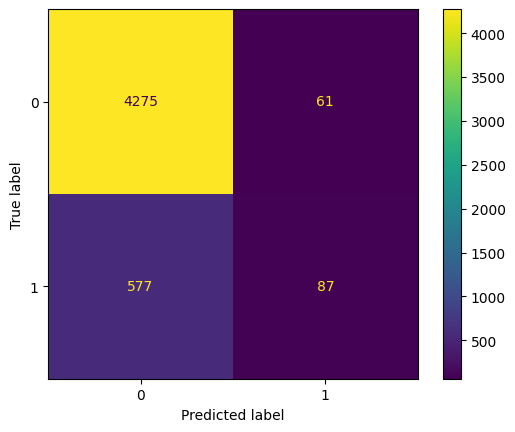

In [12]:
confusionMatricePlot(y_test, y_prediction)

***
### Naive Bayes
***

In [13]:
from sklearn.inspection import permutation_importance
from sklearn.naive_bayes import MultinomialNB

X = df_model[col_to_keep]
y = df_model['comments_binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.25, shuffle=True)

classifier = MultinomialNB()
classifier.fit(X_train, y_train)
y_prediction = classifier.predict(X_test)

In [14]:
modelScore(y_test, y_prediction)

Accuracy: 0.51
Precision: 0.17
Recall: 0.71
f1_score: 0.27


In [15]:
featureImportance(classifier, X_train, y_test)


Feature Importance:
             feature  importance
8   time_difference     0.03736
24  comments_binary     0.00184
6        like_count     0.00128
13          weekday     0.00012
20          weekday     0.00012
19          weekday     0.00012
14          weekday     0.00012
23      emoji_count     0.00000
22         negative     0.00000
21         positive     0.00000
16             year     0.00000
15             year     0.00000
0   IDENTITY_ATTACK     0.00000
1            INSULT     0.00000
10             year     0.00000
9              year     0.00000
5          TOXICITY     0.00000
4            THREAT     0.00000
3   SEVERE_TOXICITY     0.00000
2         PROFANITY     0.00000
11            month    -0.00008
17            month    -0.00008
18            month    -0.00008
12            month    -0.00008
7            shares    -0.00036


***
### Gradient-Boosting
***

***
Visualisation
***

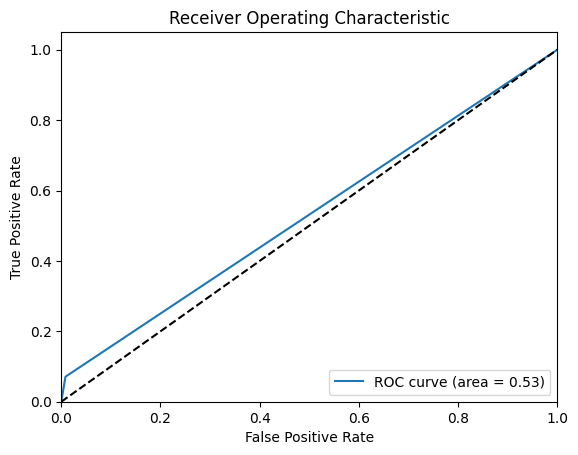

In [88]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_prediction)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()